In [ ]:
%pip install atproto
from atproto import Client
from datetime import datetime, timezone
import calendar

# Initialize the client
client = Client()
client.login('abol3nin7744@gmail.com', 'Ahmed12345')
client.service = 'https://public.api.bsky.app'

# Parameters
query = 'Environment'
all_posts = []
cursor = None
day = 1
month = 1
year = 2023

# Time periods
periods = [
    {'start_hour': 0, 'end_hour': 12, 'label': 'AM'},  # 12 AM - 12 PM
    {'start_hour': 12, 'end_hour': 23, 'label': 'PM'}  # 12 PM - 12 AM
]

# Function to fetch posts for a given time period
def fetch_posts_for_period(start_datetime, end_datetime, cursor=None):
    params = {
        'q': query,
        'limit': 100,
        'sort': 'latest',
        'since': start_datetime.isoformat(),
        'until': end_datetime.isoformat(),
        'cursor': cursor
    }
    data = client.app.bsky.feed.search_posts(params=params)
    return data

# Main loop to fetch posts for the given query
while year <= 2024:  # Explicitly limit the year to 2024
    _, last_day_of_month = calendar.monthrange(year, month)
    while day <= last_day_of_month:  # Loop until the last day of the month
        try:
            # Format the date for the current day
            current_day_start = datetime(year, month, day, 0, 0, 0, tzinfo=timezone.utc)

            # Process each period (AM and PM)
            for period in periods:
                # Calculate the start and end times for the current period
                start_datetime = current_day_start.replace(hour=period['start_hour'], minute=0, second=0)
                end_datetime = current_day_start.replace(hour=period['end_hour'], minute=0, second=0)

                print(f"Fetching posts for {period['label']} period: Day {day}, Month {month}, Year {year} ({start_datetime.hour}:00 - {end_datetime.hour}:00)")

                # Fetch posts for the current period
                data = fetch_posts_for_period(start_datetime, end_datetime, cursor)
                all_posts.extend(data.posts)

                # Update cursor if it exists
                if hasattr(data, 'cursor'):
                    cursor = data.cursor
                else:
                    break  # Break out of the inner loop (periods) if no more cursor

        except Exception as e:  # Handle potential errors during fetching
            print(f"An error occurred: {e}")

        day += 1

    # Reset day and increment month/year for the next iteration
    day = 1
    month += 1
    if month > 12:
        month = 1
        year += 1

Fetching posts for AM period: Day 1, Month 1, Year 2023 (0:00 - 12:00)
Fetching posts for PM period: Day 1, Month 1, Year 2023 (12:00 - 23:00)
Fetching posts for AM period: Day 2, Month 1, Year 2023 (0:00 - 12:00)
Fetching posts for PM period: Day 2, Month 1, Year 2023 (12:00 - 23:00)
Fetching posts for AM period: Day 3, Month 1, Year 2023 (0:00 - 12:00)
Fetching posts for PM period: Day 3, Month 1, Year 2023 (12:00 - 23:00)
Fetching posts for AM period: Day 4, Month 1, Year 2023 (0:00 - 12:00)
Fetching posts for PM period: Day 4, Month 1, Year 2023 (12:00 - 23:00)
Fetching posts for AM period: Day 5, Month 1, Year 2023 (0:00 - 12:00)
Fetching posts for PM period: Day 5, Month 1, Year 2023 (12:00 - 23:00)
Fetching posts for AM period: Day 6, Month 1, Year 2023 (0:00 - 12:00)
Fetching posts for PM period: Day 6, Month 1, Year 2023 (12:00 - 23:00)
Fetching posts for AM period: Day 7, Month 1, Year 2023 (0:00 - 12:00)
Fetching posts for PM period: Day 7, Month 1, Year 2023 (12:00 - 23:00)

In [ ]:
# Initialize empty lists to store data
post_number = []
text_data = []
created_at_data = []
author_data = []
like_count_data = []
reply_count_data = []
repost_count_data = []
reply = []
uri_of_post = []

i=0
# Extract data from feed_data
for post in all_posts:
    i+=1
    # The 'record', 'author', etc. attributes are directly accessible under 'post' (PostView object)
    post_number.append(i)
    text_data.append(post.record.text if post.record.text else "")
    created_at_data.append(post.record.created_at)
    author_data.append(post.author.handle)
    like_count_data.append(post.like_count)
    reply_count_data.append(post.reply_count)
    repost_count_data.append(post.repost_count)
    uri_of_post.append(post.uri)
    # replies_data.append(print_replies(post))

In [ ]:
def print_replies(thread_post, level=1):
    """Recursively prints replies within a thread, including the timestamp."""
    replies_text = []  # List to store reply texts

    if hasattr(thread_post, 'replies') and thread_post.replies:
        for reply in thread_post.replies:
            if hasattr(reply, 'post') and hasattr(reply.post, 'record'):
                reply_text = reply.post.record.text
                reply_created_at = reply.post.record.created_at

                # Append the formatted reply text to replies_text
                replies_text.append(f"Reply (Level {level}): {reply_text} \n Created At: {reply_created_at}")

                # Recursively call to print nested replies if any
                replies_text.extend(print_replies(reply, level + 1))  # Extend with nested replies
    elif hasattr(thread_post, 'post') and hasattr(thread_post.post, 'record') and hasattr(thread_post.post, 'reply'):
        # Check if it's a direct reply to a post
        reply_text = thread_post.post.record.text
        reply_created_at = thread_post.post.record.created_at
        replies_text.append(f"Reply (Level {level}): {reply_text} \n Created At: {reply_created_at}")

    # Return the list of reply texts
    return replies_text


In [ ]:
import pandas as pd
from atproto import Client

# Assuming you have already initialized the 'client' and 'all_posts'

def get_all_comments(all_posts, client):
    """Retrieves all comments for all posts, including post number and URI."""
    all_comments_data = []
    for i, post in enumerate(all_posts):
        try:
            # Fetch the thread for the current post
            res = client.get_post_thread(uri=post.uri)
            # Check if the thread has a post and replies
            if hasattr(res, 'thread') and hasattr(res.thread, 'replies'):
                for reply in res.thread.replies:
                    if hasattr(reply, 'post') and hasattr(reply.post, 'record'):
                        reply_text = reply.post.record.text
                        reply_created_at = reply.post.record.created_at
                        all_comments_data.append({
                            "Post Number": i + 1,
                            "uri of the post": post.uri,
                            "Comment": reply_text,
                            "Comment Created At": reply_created_at
                        })
            else:
                # If no replies, add a row with an empty comment
                all_comments_data.append({
                    "Post Number": i + 1,
                    "uri of the post": post.uri,
                    "Comment": "",
                    "Comment Created At": ""
                })
        except Exception as e:
            print(f"Failed to retrieve thread for {post.uri}: {e}")
            # Add a row with an error message for posts with thread retrieval failures
            all_comments_data.append({
                "Post Number": i + 1,
                "uri of the post": post.uri,
                "Comment": f"Error retrieving thread: {e}",
                "Comment Created At": ""
            })
    return all_comments_data

# Get all comments using the new function
all_comments = get_all_comments(all_posts, client)  # Pass the 'client' object

# Create a pandas DataFrame
df_all_comments = pd.DataFrame(all_comments)

# Save to CSV
df_all_comments.to_csv('all_comments.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('all_comments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install openpyxl
import pandas as pd
import openpyxl # Import the openpyxl engine


# Create a pandas DataFrame
df = pd.DataFrame(all_comments)

# Save the DataFrame to a CSV file
df.to_excel('bluesky_COMMENTS_data_XLSX.xlsx', index=False, engine='openpyxl') # Specify the engine

# Download the CSV file
from google.colab import files
files.download('bluesky_COMMENTS_data_XLSX.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tabulate import tabulate

# Create a list of dictionaries, where each dictionary represents a row in the table
table_data = []
for i in range(len(text_data)):
    table_data.append({
        "Post Number": i + 1,
        "Topic" :  query,
        "URI": uri_of_post[i],
        "user" : author_data[i],
        "Post": text_data[i],
        "Time": created_at_data[i],
        "Likes": like_count_data[i],
        "Nb.comments": reply_count_data[i],
        "Nb.reposts": repost_count_data[i]
    })

# Print the table using tabulate
#print(tabulate(table_data, headers="keys", tablefmt="grid"))

In [ ]:
import pandas as pd

# Create a pandas DataFrame
df = pd.DataFrame(table_data)

# Save the DataFrame to a CSV file
df.to_csv('bluesky_SearchingPosts_HEALTH_CSV.csv', index=False)

# Download the CSV file
from google.colab import files
files.download('bluesky_SearchingPosts_HEALTH_CSV.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install openpyxl
import pandas as pd
import openpyxl # Import the openpyxl engine


# Create a pandas DataFrame
df = pd.DataFrame(table_data)

# Save the DataFrame to a CSV file
df.to_excel('bluesky_SearchingPosts_data_XLSX.xlsx', index=False, engine='openpyxl') # Specify the engine

# Download the CSV file
from google.colab import files
files.download('bluesky_SearchingPosts_data_XLSX.xlsx')

IllegalCharacterError: The course International Climate Governance is for anyone interested in the law and economics of #climatechange & #climatejustice. In Bern or online, from 1 to 5 July, it’s your change to stay ahead of the competition! Apply now!

www.wti.org/summer

youtu.be/q_XLd5rc5xw?... cannot be used in worksheets.

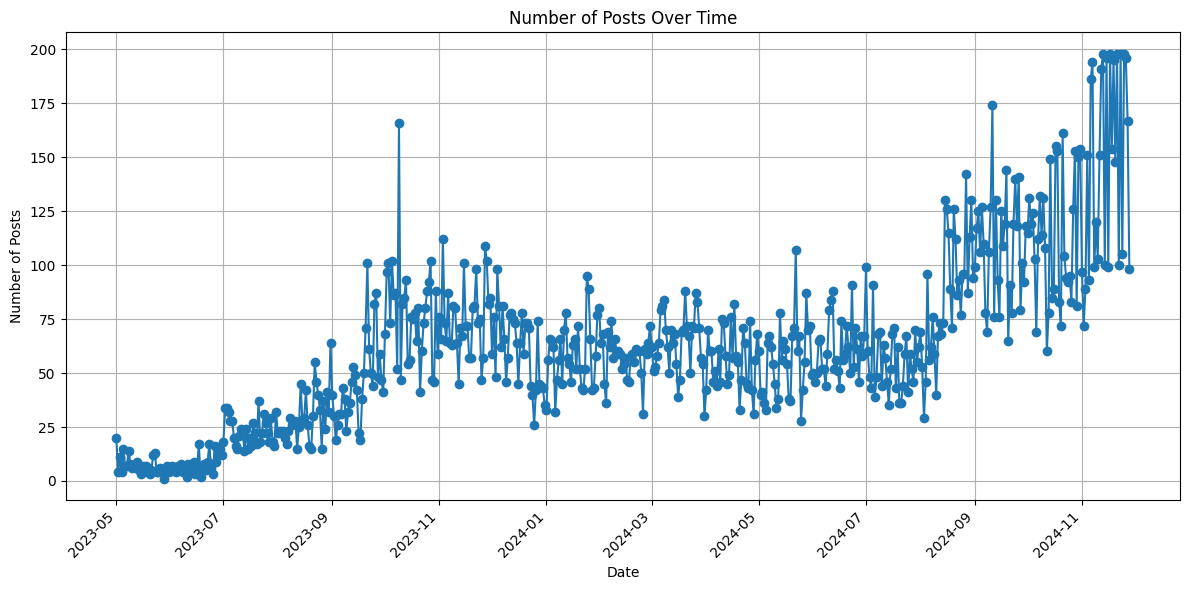

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'created_at_data' to datetime objects, handling errors
created_at_datetime = pd.to_datetime(created_at_data, format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce') # Changed errors to 'raise' to see the actual errors during conversion

# Create a pandas Series from the DatetimeIndex
created_at_series = pd.Series(created_at_datetime)

# Remove NaT values to ensure all elements are datetime-like
created_at_series = created_at_series.dropna()

# Create a pandas Series with the datetime objects and counts
post_counts = created_at_series.dt.date.value_counts().sort_index() # Use .dt on the Series

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(post_counts.index, post_counts.values, marker='o', linestyle='-')
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()